# Shapley Tests

## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple, List

# Standard Libraries
from enum import Enum, auto
from pathlib import Path
from math import sqrt, pi, sin, cos, tan, radians
from statistics import mean
from itertools import zip_longest
from dataclasses import dataclass, field, asdict

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
#import PySimpleGUI as sg
import pydicom
import shapely
from shapely.plotting import plot_polygon, plot_points

# Local functions and classes
from utilities import *
from types_and_classes import *


### Global Settings

In [2]:
PRECISION = 3


In [3]:
%matplotlib inline

## DE-9IM Relationships
[DE-9IM](https://en.wikipedia.org/wiki/DE-9IM)


The DE-9IM model is based on a 3×3 intersection matrix with the form:

![DE-9IM Matrix](attachment:image.png)

where 
_dim_ is the dimension of the intersection (∩) of the interior (I), boundary (B), and exterior (E) of geometries a and b.

Visually, for two overlapping polygonal geometries, the result of the function DE_9IM(a,b) looks like:

![DE_9IM Example](Images/DE-9IM.png)


This matrix can be serialized. Reading from left-to-right and top-to-bottom, the result is

![image.png](attachment:image.png)

 So, in a compact representation as string code is '212101212'.

### Testing the StructureSlice Class

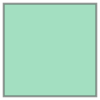

In [4]:
box6 = shapely.Polygon(box_points(6))
a = StructureSlice([box6])
a.contour

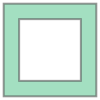

In [5]:
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
a = StructureSlice([box6, box4])
a.contour

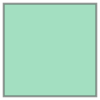

In [6]:
a.exterior

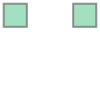

In [7]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
a = StructureSlice([box2a, box2b])
a.contour

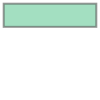

In [8]:
a.hull

In [9]:
### Simple overlap
box6 = shapely.Polygon(box_points(6))
offset_box6 = shapely.Polygon(box_points(6,offset_x=3))
try:
    StructureSlice([box6, offset_box6])
except ValueError as err:
    print(err)

Cannot merge overlapping contours.


In [10]:
# Inverted order
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
try:
    StructureSlice([box4, box6])
except ValueError as err:
    print(err)

Cannot merge overlapping contours.


## Relationship Functions

### Testing compare function

In [11]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
compare(box6, box4)

'111001001'

In [12]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
compare(box6, box6)

'100010001'

In [13]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
compare(box2a, box2b)

'001001111'

In [14]:
# compare with empty contour
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
mt = shapely.MultiPolygon()
compare(box6, mt)

'001001001'

In [15]:
# compare with empty contour
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
mt = shapely.MultiPolygon()
compare(mt, box6)

'000000111'

### Testing relate function

In [16]:
box6 = shapely.Polygon(box_points(6))
box4 = shapely.Polygon(box_points(4))
a = StructureSlice([box6])
b = StructureSlice([box4])
bin(relate(a,b))

'0b111001001111001001111001001'

In [17]:
box6 = shapely.Polygon(box_points(6))
a = StructureSlice([box6])
bin(relate(a,a))

'0b100010001100010001100010001'

In [18]:
# 2 2x2 boxes
box2a = shapely.Polygon(box_points(2, offset_x=-3))
box2b = shapely.Polygon(box_points(2, offset_x=3))
a = StructureSlice([box2a])
b = StructureSlice([box2b])
bin(relate(a,b))

'0b1001111001001111001001111'

## Named Relationship Identification

### Testing RelationshipType

In [19]:
bool(RelationshipType.UNKNOWN)

False

In [20]:
bool(RelationshipType.LOGICAL)

True

# Relationship Types and Definitions

### Color Coding
<table style="border: 2px solid black; width=50px;"><tr><td>
<ul style="font-weight: 900; font-size: 20px;">
<li style="color: blue;">region a</li>
<li style="color: green;">region b</li>
<li style="color: orange;">intersection of a & b</li></ul>
</tr></td></>

## Disjoint Relations


### Surrounds

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Surrounds</th><th>Transitive</t></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> have no interior points in common, and with holes filled <span class="b">b</span> lies in the interior of <span class="a">a</span>.
</td></tr><tr><td>
<img src="Images/Relationships/surrounds simple.png" alt="surrounds simple">
<img src="Images/Relationships/surrounds with ring.png" alt="surrounds ring">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>*</td></tr>
    <tr><td>*</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>100010110</span></td><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>100000000</span></td><td><span>000000000</span></td></tr>
</table></td></tr></table>


In [21]:
surrounds_def = RelationshipTest(RelationshipType.SURROUNDS,
                                 0b000000000100010110110110000,
                                 0b000000000100000000000000000)

def surrounds_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    return a, b

def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    return a, b

Surounds Mask  000000000  |  100010110  |  110110000 
Surounds Value  000000000  |  100000000  |  000000000 
Relation Binary  111001001  |  111001001  |  001001111 
Relationship RelationshipType.SURROUNDS


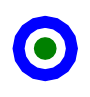

In [22]:
print('Surounds Mask', bin_format(surrounds_def.mask))
print('Surounds Value', bin_format(surrounds_def.value))

a, b = surrounds_example1()
relation_example(a, b, surrounds_def)


Relation Binary  111001001  |  111001001  |  001001111 
Relationship RelationshipType.SURROUNDS


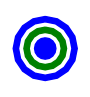

In [23]:
a, b = surrounds_example2()
relation_example(a, b, surrounds_def)

### Shelters

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Shelters</th><th>Transitive</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have no points in common, 
but the Convex Hull of <span class="a">a</span> contains <span class="b">b</span>.
</td></tr>
<tr><td>
<img src="Images/Relationships/shelters.png" alt="Shelters">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>2</td><td>1</td><td>2</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    <tr><td>F</td><td>*</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>111000100</span></td><td><span>110110000</span></td><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>111000000</span></td><td><span>000000000</span></td><td><span>000000000</span></td></tr>
</table></td></tr></table>

In [24]:
shelters_def = RelationshipTest(RelationshipType.SHELTERS,
                                0b111000100110110000110110000,
                                0b111000000000000000000000000)

def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])
    return a, b


Shelters Mask  111000100  |  110110000  |  110110000 
Shelters Value  111000000  |  000000000  |  000000000 
Relation Binary  111001001  |  001001111  |  001001111 
Relationship RelationshipType.SHELTERS


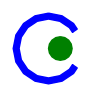

In [25]:
print('Shelters Mask', bin_format(shelters_def.mask))
print('Shelters Value', bin_format(shelters_def.value))

a, b = shelters_example()
relation_example(a, b, shelters_def)

### Disjoint

<link rel="stylesheet" href="relations.css">
<table width="600px">
<tr class="l"><th>Disjoint</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The Convex Hull of 
<span class="a">a</span> has no points in common wuth <span class="b">b</span>.</td></tr>
<tr><td>
<img src="Images/Relationships/disjoint.png" alt="Disjoint" style="width: 640px">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>110110000</span></td><td><span>110110000</span></td><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>000000000</span></td></tr>
</table></td></tr></table>

In [26]:
disjoint_def = RelationshipTest(RelationshipType.DISJOINT,
                                0b110110000110110000110110000,
                                0b000000000000000000000000000)

def disjoint_example():
    circle4_left = shapely.Polygon(circle_points(4, offset_x=-4.5))
    circle4_right = shapely.Polygon(circle_points(4, offset_x=4.5))

    a = StructureSlice([circle4_left])
    b = StructureSlice([circle4_right])
    return a, b


Disjoint Mask  110110000  |  110110000  |  110110000 
Disjoint Value  000000000  |  000000000  |  000000000 
Relation Binary  001001111  |  001001111  |  001001111 
Relationship RelationshipType.DISJOINT


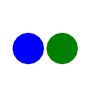

In [27]:
print('Disjoint Mask', bin_format(disjoint_def.mask))
print('Disjoint Value', bin_format(disjoint_def.value))

a, b = disjoint_example()
relation_example(a, b, disjoint_def)

## Border Relations

### Borders

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Borders</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The exterior boundaries of 
<span class="a">a</span> and <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr>
<tr><td>
<img src="Images/Relationships/borders.png" alt="Borders">
<img src="Images/Relationships/Concave Borders.png" alt="Concave Borders">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>*</td><td>*</td><td>2</td></tr>
    <tr><td>*</td><td>*</td><td>1</td></tr>
    <tr><td>2</td><td>1</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>1</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>001001110</span></td><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>001001110</span></td><td><span>000010000</span></td></tr>
</table></td></tr></table>

In [28]:
borders_def = RelationshipTest(RelationshipType.BORDERS,
                               0b000000000001001110110110000,
                               0b000000000001001110000010000)

def borders_example1():
    box4_left = shapely.Polygon(box_points(4, offset_x=-2))
    box4_right = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([box4_left])
    b = StructureSlice([box4_right])
    return a, b

def borders_example2():
    box6 = shapely.Polygon(box_points(6))
    box5_up = shapely.Polygon(box_points(5, offset_y=3))
    box6_cropped = shapely.difference(box6, box5_up)

    a = StructureSlice([box6_cropped])
    b = StructureSlice([box5_up])
    return a, b

Borders Mask  000000000  |  001001110  |  110110000 
Borders Value  000000000  |  001001110  |  000010000 
Relation Binary  001011111  |  001011111  |  001011111 
Relationship RelationshipType.BORDERS


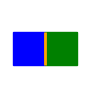

In [29]:
print('Borders Mask', bin_format(borders_def.mask))
print('Borders Value', bin_format(borders_def.value))

a, b = borders_example1()
relation_example(a, b, borders_def)

Relation Binary  111101111  |  001011111  |  001011111 
Relationship RelationshipType.BORDERS


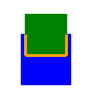

In [30]:
a, b = borders_example2()
relation_example(a, b, borders_def)

### Confines

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Confines</th><th>Symmetric</th></tr>
<td class="d" colspan="2">The interior boundary of <span class="a">a</span> 
and the exterior boundary of <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr>
<tr><td>
<img src="Images/Relationships/confines.png" alt="Confines">
<img src="Images/Relationships/confines with island.png" alt="Confines With Island">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>*</td><td>*</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>2</td></tr>
    <tr><td>*</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    </table>
    </td>
<td><table class="matrix">        
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>1</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>101010110</span></td><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>101000000</span></td><td><span>000010000</span></td></tr>
</table></td></tr></table>

**For Confines _b_ Should be Within _a_**

In [31]:
confines_def = RelationshipTest(RelationshipType.CONFINES,
                                0b000000000101010110110110000,
                                0b000000000101000000000010000)

def confines_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))
    cropped_circle = shapely.difference(circle4, box4_offset)

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_circle])
    return a, b

def confines_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

def confines_example3():
    # 6 cm x 6 cm box with 4cm x 4 cm hole
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    a = StructureSlice([box6, box4])
    b = StructureSlice([box4])
    return a, b

Confines Mask  000000000  |  101010110  |  110110000 
Confines Value  000000000  |  101000000  |  000010000 
Relation Binary  111001001  |  111001001  |  001011111 
Relationship RelationshipType.CONFINES


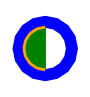

In [32]:
print('Confines Mask', bin_format(confines_def.mask))
print('Confines Value', bin_format(confines_def.value))

a, b = confines_example1()
relation_example(a, b, confines_def)

Relation Binary  111001001  |  111001001  |  001011101 
Relationship RelationshipType.CONFINES


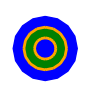

In [33]:
a, b = confines_example2()
relation_example(a, b, confines_def)

Relation Binary  111001001  |  111001001  |  001011101 
Relationship RelationshipType.CONFINES


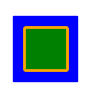

In [34]:
a, b = confines_example3()
relation_example(a, b, confines_def)

### Partition

<link rel="stylesheet" href="relations.css">
<table width="700px">
<tr class="l"><th>Partition</th><th></th></tr>
<td class="d" colspan="2">
The boundaries of <span class="a">a</span> and <span class="b">b</span> have more than one point in common.
No points of <span class="b">b</span> are exterior to <span class="a">a</span>, and some points in <span class="a">a</span> are exterior to <span class="b">b</span>.
</td></tr>
<tr><td width=300>
<img src="Images/Relationships/partitions simple.png" alt="Partition">
<img src="Images/Relationships/partitions archipelago with island.png" alt="Partition With Island">
<img src="Images/Relationships/partitions partial ring.png" alt="Partition Ring">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>2</td></tr>
    <tr><td>*</td><td>1</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101010110</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101010000</span></td></tr>
</table></td></tr></table>

In [ ]:
partition_def = RelationshipTest(RelationshipType.PARTITION,
                                0b000000000000000000101010110,
                                0b000000000000000000101010000)

def partition_example1():
    box6 = poly_round(shapely.Polygon(box_points(6)))
    box4_offset = shapely.Polygon(box_points(4, offset_x=-1))
    a = StructureSlice([box6])
    b = StructureSlice([box4_offset])
    return a, b

def partition_example2():
    # Rouding required because pod floating point inaccuracies.
    circle6 = poly_round(shapely.Polygon(circle_points(3)))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=2))
    cropped_circle = poly_round(shapely.intersection(circle6, circle4_offset))
    a = StructureSlice([circle6])
    b = StructureSlice([cropped_circle])
    return a, b

def partition_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle2])
    return a, b

def partition_example4():
    # Rouding required because pod floating point inaccuracies.
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    box6_offset = shapely.Polygon(box_points(6, offset_x=2))
    ring = shapely.difference(circle6, circle4)
    cropped_ring = poly_round(shapely.difference(ring, box6_offset),PRECISION)
    a = StructureSlice([circle6, circle4])
    b = StructureSlice([cropped_ring])
    return a, b

Partition Mask  000000000  |  000000000  |  101010110 
Partition Value  000000000  |  000000000  |  101010000 
Relation Binary  111011001  |  111011001  |  111011001 
Relationship RelationshipType.PARTITION


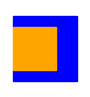

In [ ]:
print('Partition Mask', bin_format(partition_def.mask))
print('Partition Value', bin_format(partition_def.value))

a, b = partition_example1()
relation_example(a, b, partition_def)

Relation Binary  111011001  |  111011001  |  111011001 
Relationship RelationshipType.PARTITION


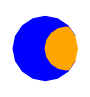

In [ ]:
a, b = partition_example2()
relation_example(a, b, partition_def)

Relation Binary  111001001  |  111001001  |  101011001 
Relationship RelationshipType.PARTITION


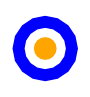

In [ ]:
a, b = partition_example3()
relation_example(a, b, partition_def)

Partition Mask  000000000  |  000000000  |  101010110 
Partition Value  000000000  |  000000000  |  101010000 
Relation Binary  111011001  |  111011001  |  111011001 
Relationship RelationshipType.PARTITION


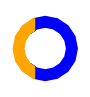

In [ ]:
print('Partition Mask', bin_format(partition_def.mask))
print('Partition Value', bin_format(partition_def.value))

a, b = partition_example4()
relation_example(a, b, partition_def)

## Contains

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td width=300>
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>2</td></tr>
    <tr><td>*</td><td>F</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101010110</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101000000</span></td></tr>
</table></td></tr></table>

In [ ]:
contains_def = RelationshipTest(RelationshipType.CONTAINS,
                                0b000000000000000000101010110,
                                0b000000000000000000101000000)

def contains_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b

def contains_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle3])
    b = StructureSlice([circle2])
    return a, b

def contains_example3():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle2])
    b = StructureSlice([circle5, circle3])
    return a, b

Contains Mask  000000000  |  000000000  |  101010110 
Contains Value  000000000  |  000000000  |  101000000 
Relation Binary  111001001  |  111001001  |  111001001 
Relationship RelationshipType.CONTAINS


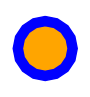

In [ ]:
print('Contains Mask', bin_format(contains_def.mask))
print('Contains Value', bin_format(contains_def.value))

a, b = contains_example1()
relation_example(a, b, contains_def)

Relation Binary  111001001  |  111001001  |  111001001 
Relationship RelationshipType.CONTAINS


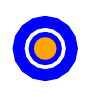

In [ ]:
a, b = contains_example2()
relation_example(a, b, contains_def)

Relation Binary  111001001  |  111001001  |  111001001 
Relationship RelationshipType.CONTAINS


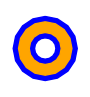

In [ ]:
a, b = contains_example3()
relation_example(a, b, contains_def)

## Overlaps

<link rel="stylesheet" href="relations.css">
<table width="760px">
<tr class="l"><th>Overlaps</th><th>Symmetric</th></tr>
<td class="d" colspan="2">
<span class="a">a</span> and <span class="b">b</span> 
have some but not all points in common.
</td></tr>
<tr><td width=300>
<img src="Images/Relationships/overlaps simple.png" alt="Overlaps">
<img src="Images/Relationships/overlaps ring.png" alt="Overlaps With Ring">
<img src="Images/Relationships/overlaps surounded.png" alt="Overlaps Surrounded">
<img src="Images/Relationships/overlaps ring surrounds simple.png" alt="Ring Overlaps Simple">
<img src="Images/Relationships/archipelago contains simple.png" alt="Ring Overlaps Simple">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>2</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    <tr><td>2</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101000100</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101000100</span></td></tr>
</table></td></tr></table>

In [35]:
overlaps_def = RelationshipTest(RelationshipType.OVERLAPS,
                                0b000000000000000000101000100,
                                0b000000000000000000101000100)

def overlaps_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([circle6])
    b = StructureSlice([circle6_offset])
    return a, b

def overlaps_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2.5))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle6_offset])
    return a, b

def overlaps_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1.5, offset_x=1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    return a, b

def overlaps_ring_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle4 = shapely.Polygon(circle_points(2))

    a = StructureSlice([circle6, circle3])
    b = StructureSlice([circle4])
    return a, b

def overlaps_archipelago_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4])
    return a, b


Overlaps Mask  000000000  |  000000000  |  101000100 
Overlaps Value  000000000  |  000000000  |  101000100 
Relation Binary  111101111  |  111101111  |  111101111 
Relationship RelationshipType.OVERLAPS


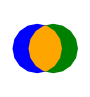

In [36]:
print('Overlaps Mask', bin_format(overlaps_def.mask))
print('Overlaps Value', bin_format(overlaps_def.value))

a, b = overlaps_simple_example()
relation_example(a, b, overlaps_def)

Relation Binary  111101111  |  111101111  |  111101111 
Relationship RelationshipType.OVERLAPS


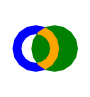

In [37]:
a, b = overlaps_ring_example()
relation_example(a, b, overlaps_def)

Relation Binary  111001001  |  111001001  |  111101111 
Relationship RelationshipType.OVERLAPS


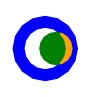

In [38]:
a, b = overlaps_surrounded_example()
relation_example(a, b, overlaps_def)

Relation Binary  111001001  |  111001001  |  111101101 
Relationship RelationshipType.OVERLAPS


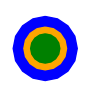

In [39]:
a, b = overlaps_ring_surrounded_example()
relation_example(a, b, overlaps_def)

Relation Binary  111001001  |  111001001  |  101111101 
Relationship RelationshipType.OVERLAPS


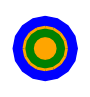

In [40]:
a, b = overlaps_archipelago_simple_example()
relation_example(a, b, overlaps_def)

## Equals

<link rel="stylesheet" href="relations.css">
<table width="400px">
<tr class="l"><th>Equals</th><th>Symmetric, Transitive</th></tr>
<td class="d" colspan="2">
The interiors of <span class="a">a</span> and <span class="b">b</span> 
intersect and no part of the interior of one geometry intersects the exterior of the other.
</td></tr>
<tr><td width=300>
<img src="Images/Relationships/equals.png" alt="Equals">
</td><td>
<table class="f">
<tr><th/><th>Hull</th><th>Exterior</th><th>Region</th></tr>
<tr><th>Matrix</th>
<td class="na">N/A</td>
<td class="na">N/A</td>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>F</td></tr>
    <tr><td>*</td><td>*</td><td>F</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>101001110</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000000000</span></td><td><span>000000000</span></td><td><span>100000000</span></td></tr>
</table></td></tr></table>

In [50]:
equals_def = RelationshipTest(RelationshipType.EQUALS,
                                0b000000000000000000101001110,
                                0b000000000000000000100000000)

def equals_example1():
    box6 = shapely.Polygon(box_points(6))
    a = StructureSlice([box6])
    b = StructureSlice([box6])
    return a, b

def equals_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    cropped_circle = shapely.intersection(circle6, circle5)
    a = StructureSlice([circle5])
    b = StructureSlice([cropped_circle])
    return a, b


Equals Mask  000000000  |  000000000  |  101001110 
Equals Value  000000000  |  000000000  |  100000000 
Relation Binary  100010001  |  100010001  |  100010001 
Relationship RelationshipType.EQUALS


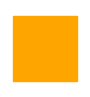

In [51]:
print('Equals Mask', bin_format(equals_def.mask))
print('Equals Value', bin_format(equals_def.value))

a, b = equals_example1()
relation_example(a, b, equals_def)

Relation Binary  100010001  |  100010001  |  100010001 
Relationship RelationshipType.EQUALS


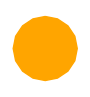

In [52]:
a, b = equals_example2()
relation_example(a, b, equals_def)

## Relationship Test Definitions

In [53]:
surrounds_def = RelationshipTest(RelationshipType.SURROUNDS,
                                 0b000000000100010110110110000,
                                 0b000000000100000000000000000)
shelters_def = RelationshipTest(RelationshipType.SHELTERS,
                                0b111000100110110000110110000,
                                0b111000000000000000000000000)
disjoint_def = RelationshipTest(RelationshipType.DISJOINT,
                                0b110110000110110000110110000,
                                0b000000000000000000000000000)
borders_def = RelationshipTest(RelationshipType.BORDERS,
                               0b000000000001001110110110000,
                               0b000000000001001110000010000)
confines_def = RelationshipTest(RelationshipType.CONFINES,
                                0b000000000101010110110110000,
                                0b000000000101000000000010000)
overlaps_def = RelationshipTest(RelationshipType.OVERLAPS,
                                0b000000000000000000101000100,
                                0b000000000000000000101000100)
partition_def = RelationshipTest(RelationshipType.PARTITION,
                                0b000000000000000000101010110,
                                0b000000000000000000101010000)
contains_def = RelationshipTest(RelationshipType.CONTAINS,
                                0b000000000000000000101010110,
                                0b000000000000000000101000000)
equals_def = RelationshipTest(RelationshipType.EQUALS,
                                0b000000000000000000101001110,
                                0b000000000000000000100000000)


In [54]:
test_binaries = [
    surrounds_def,
    shelters_def,
    disjoint_def,
    borders_def,
    confines_def,
    overlaps_def,
    partition_def,
    contains_def,
    equals_def
    ]

In [55]:
def find_type(relation_binary, test_binaries):
    for rel_def in test_binaries:
        result = rel_def.test(relation_binary)
        if result:
            return result
    return RelationshipType.UNKNOWN

In [56]:
test_relations = [
    surrounds_example1,
    surrounds_example2,
    shelters_example,
    disjoint_example,
    borders_example1,
    borders_example2,
    confines_example1,
    confines_example2,
    overlaps_simple_example,
    overlaps_ring_example,
    overlaps_surrounded_example,
    overlaps_ring_surrounded_example,
    overlaps_archipelago_simple_example,
    partition_example1,
    partition_example2,
    partition_example3,
    partition_example4,
    contains_example1,
    contains_example2,
    contains_example3,
    equals_example1,
    equals_example2
]


#### Testing identify_relation function

In [57]:
results = []
for rel_test in test_relations:
    a, b = rel_test()
    relation_binary = relate(a,b)
    relation_name = identify_relation(relation_binary)
    result = f'{rel_test.__name__:>40s}\t{bin_format(relation_binary)}\t{str(relation_name)}'
    results.append(result)

for r in results:
    print(r)

                      surrounds_example1	 111001001  |  111001001  |  001001111 	RelationshipType.SURROUNDS
                      surrounds_example2	 111001001  |  111001001  |  001001111 	RelationshipType.SURROUNDS
                        shelters_example	 111001001  |  001001111  |  001001111 	RelationshipType.SHELTERS
                        disjoint_example	 001001111  |  001001111  |  001001111 	RelationshipType.DISJOINT
                        borders_example1	 001011111  |  001011111  |  001011111 	RelationshipType.BORDERS
                        borders_example2	 111101111  |  001011111  |  001011111 	RelationshipType.BORDERS
                       confines_example1	 111001001  |  111001001  |  001011111 	RelationshipType.CONFINES
                       confines_example2	 111001001  |  111001001  |  001011101 	RelationshipType.CONFINES
                 overlaps_simple_example	 111101111  |  111101111  |  111101111 	RelationshipType.OVERLAPS
                   overlaps_ring_exam

## Mask Ranking

In [58]:
test_binaries = [
    surrounds_def,
    shelters_def,
    disjoint_def,
    borders_def,
    confines_def,
    overlaps_def,
    partition_def,
    contains_def,
    equals_def
    ]

In [59]:
test_binaries

[RelationshipTest(RelationshipType.SURROUNDS
     mask =  0b000000000100010110110110000
     value = 0b000000000100000000000000000,
 RelationshipTest(RelationshipType.SHELTERS
     mask =  0b111000100110110000110110000
     value = 0b111000000000000000000000000,
 RelationshipTest(RelationshipType.DISJOINT
     mask =  0b110110000110110000110110000
     value = 0b000000000000000000000000000,
 RelationshipTest(RelationshipType.BORDERS
     mask =  0b000000000001001110110110000
     value = 0b000000000001001110000010000,
 RelationshipTest(RelationshipType.CONFINES
     mask =  0b000000000101010110110110000
     value = 0b000000000101000000000010000,
 RelationshipTest(RelationshipType.OVERLAPS
     mask =  0b000000000000000000101000100
     value = 0b000000000000000000101000100,
 RelationshipTest(RelationshipType.PARTITION
     mask =  0b000000000000000000101010110
     value = 0b000000000000000000101010000,
 RelationshipTest(RelationshipType.CONTAINS
     mask =  0b00000000000000000010101

In [60]:
test_binaries.sort(key=lambda x: x.mask, reverse=True)
for test_bin in test_binaries:
    print(f'{test_bin.relation_type.name:12s}{bin_format(test_bin.mask):40s}\t{bin_format(test_bin.value):40s}')

SHELTERS     111000100  |  110110000  |  110110000  	 111000000  |  000000000  |  000000000  
DISJOINT     110110000  |  110110000  |  110110000  	 000000000  |  000000000  |  000000000  
CONFINES     000000000  |  101010110  |  110110000  	 000000000  |  101000000  |  000010000  
SURROUNDS    000000000  |  100010110  |  110110000  	 000000000  |  100000000  |  000000000  
BORDERS      000000000  |  001001110  |  110110000  	 000000000  |  001001110  |  000010000  
PARTITION    000000000  |  000000000  |  101010110  	 000000000  |  000000000  |  101010000  
CONTAINS     000000000  |  000000000  |  101010110  	 000000000  |  000000000  |  101000000  
EQUALS       000000000  |  000000000  |  101001110  	 000000000  |  000000000  |  100000000  
OVERLAPS     000000000  |  000000000  |  101000100  	 000000000  |  000000000  |  101000100  
